## FFT solver for 1D Gross-Pitaevski equation

We look for the complex function $\psi(x)$ satisfying the GP equation

$ i\partial_t \psi = -\frac{1}{2}(i\partial_x - \Omega)^2\psi+ V(x)\psi + g|\psi|^2\psi $,

with periodic boundary conditions.

Integration: pseudospectral method with split (time evolution) operator; 
that is evolving in real (R) or momentum (K) space according to the operators
in the Hamiltonian, i.e.
first we evaluate

$\hat{\psi}(x,\frac{t}{2})=\cal{F}^{-1}\left[\exp\left(-i \frac{\hbar^2 k^2}{2} \frac{t}{2}\right)\,\psi(k,0)\right] $

and later

$\psi(k,t) = \exp(-i \frac{\hbar^2 k^2}{2} \frac{t}{2})\, 
\cal{F}\left[\exp\left(-i (V(x)+|\hat{\psi}(x,\frac{t}{2})|^2)\, t \right)\,\hat{\psi}(x,\frac{t}{2}) \,
\right]$

where $\cal{F}$ is the Fourier transform.
_______________________________________________________________________________
_______________________________________________________________________________

Import libraries and general definitions
-------------------------------------------------------------------------------

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.fftpack import fft, ifft
from scipy.integrate import odeint
import numpy.linalg as lin
# comment next line to export as a python shell 
%matplotlib inline         
pi=np.pi

Data block
--------------------------------------------------------------------------------

In [2]:
Zmax = 2*pi      # Grid half length
Npoint = 128     # Number of grid points
Nparticle = 50   # Number of particles
a_s = 0.5        # scattering length 
whoz = 1.0       # harmonic oscilator angular frequency
Omega = pi/(2*Zmax)    # reference frame velocity
Ntime_fin = 10000       # total number of time steps
Ntime_out = 100       # number of time steps for intermediate outputs
Dtr = 1.0e-3           # real time step
Dti = 1.0e-3           # imaginary time step
#
# print evolution data:
#
print("Initial data:")
print(" Number of particles = %g"%(Nparticle))
print(" Harmonic oscillator angular frequency = %g"%(whoz))
print(" Domain half length = %g"%(Zmax))
print(" Number of grid points = %g"%(Npoint))
print(" Scattering length = %g"%(a_s))
print(" Total time of evolution = %g"%(Ntime_fin*Dtr))
print(" Real time step = %g"%(Dtr))
print(" Imaginary time = %g"%(Dti))
print(" Intermediate solutions = %g"%(Ntime_fin/Ntime_out-1))

Initial data:
 Number of particles = 50
 Harmonic oscillator angular frequency = 1
 Domain half length = 6.28319
 Number of grid points = 128
 Scattering length = 0.5
 Total time of evolution = 10
 Real time step = 0.001
 Imaginary time = 0.001
 Intermediate solutions = 99


Derived quantities
-------------------------------------------------------------------------------------

In [3]:
NormWF = 1.0/(2*Zmax)           # Wave function (WF) norm
gint = 2*a_s*Nparticle*NormWF   # interaction (nonlinear-term) strength
Dz = 2*Zmax/Npoint              # length step size
Dk = pi/Zmax            # momentum step size
Kmax = Dk*(Npoint//2)   # maximum momentum
Dt = Dtr-1j*Dti         # complex time
Ninter = Ntime_fin/Ntime_out # Number of outputs with the intermediate states

Utilities
-------------------------------------------------------------------------------------

In [4]:
def changeFFTposition(f,N,j):  # change the order in vectors from FFT
#    
# f(0...N-1) is the vector to order
# N is the vector dimension
# j is a switch indicating the change direction
# physical order is f=[(-(Zmax-Dz):Dz:-Dz) (0:Dz:Zmax) ]
# FFT order is f=[(0:Dk:kmax) (-(kmax-kz):kz:-kz)]
#
    f1 = f*1
    if (j==1):  # from physical to FFT order
        for i in range(0,N//2-1) : 
            f1[i] = f[N//2-1+i];
            f1[N//2+1+i] = f[i];
        f1[N//2-1] = f[N-2];        
        f1[N//2] = f[N-1];
    elif (j==0): # from FFT to physical order
        for i in range(0,N//2-1) : 
            f1[i] = f[N//2+1+i];
            f1[N//2+1+i] = f[i+2];
        f1[N//2-1] = f[0];        
        f1[N//2] = f[1];        
    else:
        print("error in changeFFTposition(f,N,j): j must be 0 or 1...")
    return f1

Grid definitions: physical and momentum space
---------------------------------------------------------------------------------------

In [5]:
z = np.arange(-Zmax+Dz,Zmax+Dz,Dz) # physical (R-space) grid points in ascending order
# zp=[(0:Dz:Zmax) (-(Zmax-Dz):Dz:-Dz)]; 
zp = changeFFTposition(z,Npoint,1) # (R-space) grid points with FFT order
#print("grid points (K-order): "); print(zp)
#print(" R-order: "); print(z)
#
# kp=[(0:Dk:Kmax) (-(Kmax-Dk):Dk:-Dk)]; # grid points (K-space), FFT order
kp = np.arange(-Kmax+Dk,Kmax+Dk,Dk)
kp = changeFFTposition(kp,Npoint,1)
#print("momentum values: "); print(kp)

Define operators
---------------------------------------------------------------------------------------

In [6]:
Ekin_K = 0.5*(kp**2)            # Kinetic energy in K space
T_K = np.exp(-1j*0.5*Dt*Ekin_K)    # time evolution operator in K space (for second order accuracy)
# print("Ekin: "); print(Ekin_K)
#
# Potential energy in R space:
# Harmonic oscillator with angular frequency whoz:
Vpot_R = 0.5*whoz*zp**2;  
# print("Vpot: "); print(Vpot_R)    

Main functions
________________________________________________________________________________________

In [7]:
def Energy(c): # Energy (per particle) calculation
    global gint, Vpot_R, Ekin_K, Npoint
    ek = sum(Ekin_K*abs(c)**2)              # Kinetic energy in K
    psi = ifft(c)*Npoint;                   # wf FFT to R
    ep = sum(Vpot_R*abs(psi)**2)/Npoint;    # Potential energy
    ei = 0.5*gint*sum(abs(psi)**4)/Npoint;  # Interaction energy
    em =  ek+ep+ei;                         # average energy
    chem_pot = em+ei;                       # chemical potential
    return em, chem_pot, ek, ep, ei
#
def T_R_psi(t,Dt,psi): # Action of the time evolution operator over state c in R space
    global gint, Vpot_R
    # Includes the external potential and the interaction operators:
    #       T_R_psi = exp(-i Dt (Vpot_R+ gint|psi|^2) ) c    
    # psi is the wave function in R space
    # t is the time (which is not used for time independant Hamiltonians)
    # Dt is the complex time step 
    #
    return np.exp( -1j*Dt*(Vpot_R + gint*(abs(psi)**2)) )*psi    # return action on psi
#
def gaussian(x,n,x0,w): # Gaussian wf in  K3
    fx = np.pi**0.25*np.exp(-0.5*((x-x0)/w)**2); # define the Gaussian in R3
    return fft(fx)/n;   # FFT to K3
#
def normaliza(c): # normalization to 1
    norm = lin.norm(c)
    if ((norm-1.0)>1.0e-4): # check norm
        print("normalization from: ",norm)
    return c/norm

Choose initial wafe function and evolve in time
__________________________________________________________________________________________

In [8]:
# initial wf: Gaussian centered at x=0 and width=1
c0=normaliza(gaussian(zp,Npoint,0,1)); # wf at t=0
# evolve in time: parameters
t0=0.0 
tevol=np.empty([Ninter+1]) # time vector
energy_cicle=np.empty([Ninter+1,5]) # put the energies in a matrix
energy_cicle[0,:] = Energy(c0) # Energies at t=0
print("Energies:          Emed    mu    Ekin    Epot    Eint")
print("         initial = %g %g %g %g %g"%(Energy(c0)))
# print("$\psi(t=0)$: "); print(ct) 
c=c0
tevol[0]=t0
j=0
t=0
for i in range(1, Ntime_fin+1): # time evolution cicle  
    t += Dt.real
    psi=ifft(T_K*c)*Npoint
    c=T_K*fft(T_R_psi(t0,Dt,psi))/Npoint
    c = normaliza(c); # check norm in the wf
    if(not(i%Ntime_out)):
        j+=1
        tevol[j] = t
        energy_cicle[j,:] = Energy(c)
print("         final   = %g %g %g %g %g"%(Energy(c))) # check energies
print("Energy change at last step  = %g"%(energy_cicle[Ninter,0]-energy_cicle[Ninter-1,0]))

/home/mva/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:5: DeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/home/mva/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:6: DeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


Energies:          Emed    mu    Ekin    Epot    Eint
         initial = 10.4736 20.4471 0.25 0.25 9.97356
         final   = 5.39136 8.91971 0.0493316 1.81367 3.52835
Energy change at last step  = -1.82104e-08


/home/mva/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:25: DeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


Plot convergence during the evolution in the average energy per particle

/home/mva/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:6: DeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/home/mva/anaconda3/lib/python3.5/site-packages/matplotlib/figure.py:397: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "


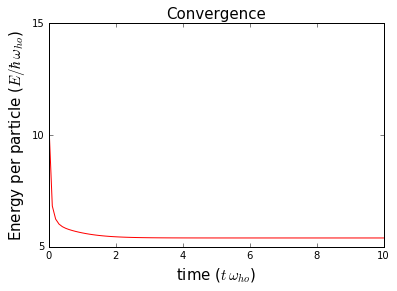

In [10]:
f1=plt.figure()
plt.title('Convergence',fontsize=15)
plt.xlabel('time ($t \, \\omega_{ho}$)',fontsize=15)
plt.ylabel('Energy per particle ($E/\\hbar \,\\omega_{ho}$)',fontsize=15)
#plt.axis([-Zmax,Zmax,0, 8])
plt.xticks(np.arange(0, tevol[Ninter]+1,tevol[Ninter]/5))
plt.locator_params('y',nbins=3)
plt.plot(tevol, energy_cicle[:,0], 'r-')
#plt.plot(z, psi, 'r.')
f1.show()

Plot the final density (or wave function)

/home/mva/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:5: DeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/home/mva/anaconda3/lib/python3.5/site-packages/matplotlib/figure.py:397: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "


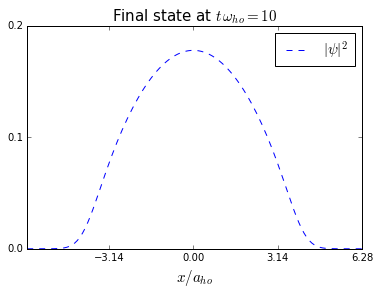

In [11]:
cc = ifft(c)*Npoint*NormWF**0.5 # FFT from K3 to R3 and include the wf norm
psi = changeFFTposition(cc,Npoint,0) # psi is the final wave function
# plot features
f2=plt.figure()
plt.title('Final state at $t \,\\omega_{ho}=%g$'%(tevol[Ninter]),fontsize=15)
plt.xlabel('$x/a_{ho}$',fontsize=15)
#plt.ylabel('$\\psi\,(x)$',fontsize=15)
#plt.axis([-Zmax,Zmax,0, 8])
plt.xticks(np.arange(-Zmax, Zmax+1,Zmax/2))
plt.locator_params('y',nbins=3)
#plt.plot(z, psi.real, 'r.',label='real$(\psi)$')
#plt.plot(z, psi.imag, 'b--',label='imag$(\psi)$')
plt.plot(z, abs(psi)**2, 'b--',label='$|\psi|^2$') # plot density
plt.legend(fontsize=15)
f2.show()